In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


In [2]:
# Define path to the CSV file
csv_path = "C:/Users/DELL/Downloads/pro machin/train.csv"  # Update with the correct path

# Read the CSV file
df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')

df.head() 

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
df.shape

(28709, 2)

In [4]:
df["emotion"].unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [5]:
df = df[df['emotion'] != 0]
df = df[df['emotion'] != 1]

In [6]:
df["emotion"].unique()

array([2, 4, 6, 3, 5], dtype=int64)

In [7]:
df.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [8]:
#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
emotion_dict = { 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

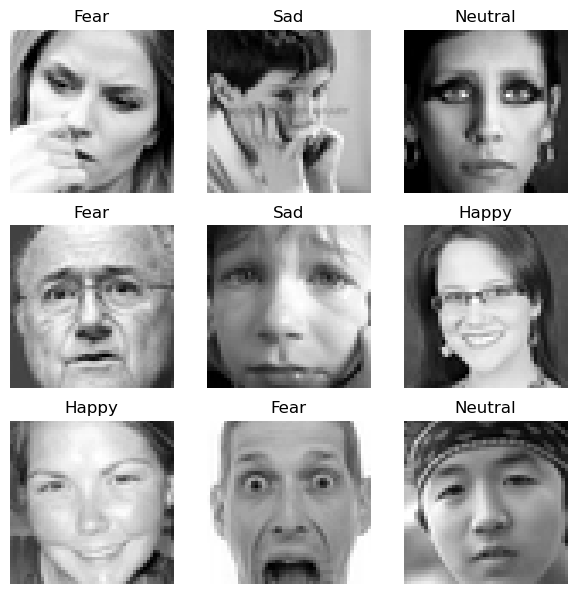

In [9]:
px = 1 / plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(720 * px, 720 * px)) 
rows = 3
columns = 3

# تأكد من أن لديك عددًا كافيًا من الصفوف لعرضها
subset_df = df.reset_index(drop=True)  # إعادة تعيين الفهرس لضمان الترتيب الصحيح

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i + 1)
    
    # استخراج البيكسلات من الصف الحالي
    pixels = np.fromstring(subset_df['pixels'].iloc[i], sep=' ')  # الوصول بالموضع
    image = pixels.reshape(48, 48)  # إعادة تشكيل الصورة
    
    plt.imshow(image, cmap='gray')
    plt.axis('off') 
    plt.title(emotion_dict.get(subset_df['emotion'].iloc[i], 'Unknown'))  # استخراج التصنيف


In [10]:
# Extract pixel values and labels
pixels = df['pixels']
labels = df['emotion']

# Initialize lists for processed data and labels
data = []
processed_labels = []

# Define image size for resizing
image_size = (64, 64)

# Dictionary to count images per label
emotion_count = {label: 0 for label in np.unique(labels)}

# Maximum images per emotion
max_images_per_emotion = 5000

In [11]:
# HOG Feature Extraction Function
def extract_hog_features(image):
    features = hog(image,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   orientations=9,
                   visualize=False)
    return features

In [12]:
# افتراض وجود DataFrame df بعد التصفية
df = df.reset_index(drop=True)  # إعادة تعيين الفهرس
emotion_count = {emotion: 0 for emotion in df["emotion"].unique()}  # إعادة تعيين العدّ لكل تصنيف

data = []
processed_labels = []

# معالجة كل صورة
for i in range(len(df)):
    try:
        label = df['emotion'].iloc[i]  # الحصول على التصنيف الحالي
        if emotion_count[label] >= max_images_per_emotion:
            continue

        # تحويل البيكسلات إلى مصفوفة
        pixel_values = np.array([int(p) for p in df['pixels'].iloc[i].split()], dtype=np.uint8)
        img = pixel_values.reshape(48, 48)

        # تغيير حجم الصورة
        img_resized = cv2.resize(img, image_size)

        # استخراج ميزات HOG
        hog_features = extract_hog_features(img_resized)

        # تخزين الميزات والتصنيفات
        data.append(hog_features)
        processed_labels.append(label)

        # تحديث عدّ الصور لهذا التصنيف
        emotion_count[label] += 1

    except Exception as e:
        print(f"Error processing row {i}: {e}")

    # تحقق من الوصول إلى الحد الأقصى لكل التصنيفات
    if all(count >= max_images_per_emotion for count in emotion_count.values()):
        break


In [13]:
# Convert to numpy arrays
data = np.array(data)
processed_labels = np.array(processed_labels)

# Shuffle the dataset
data, processed_labels = shuffle(data, processed_labels, random_state=42)

print(f"Processed {len(data)} images.")

Processed 22063 images.


In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(data, processed_labels, test_size=0.2, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)}, Test set: {len(X_test)}")

Training set: 17650, Test set: 4413


In [15]:
# initializing the model and train it

logistic = LogisticRegression(penalty='l2',solver='sag',C=1.0,max_iter=1000)
History = logistic.fit(X_train,y_train)

In [16]:
y_train_pred_log = logistic.predict(X_train)
y_test_pred_log = logistic.predict(X_test)

print(f"logistic - Train accuracy: {accuracy_score(y_train, y_train_pred_log)}")
print(f"logistic - Test accuracy: {accuracy_score(y_test, y_test_pred_log)}")

logistic - Train accuracy: 0.6107648725212464
logistic - Test accuracy: 0.48810333106730114


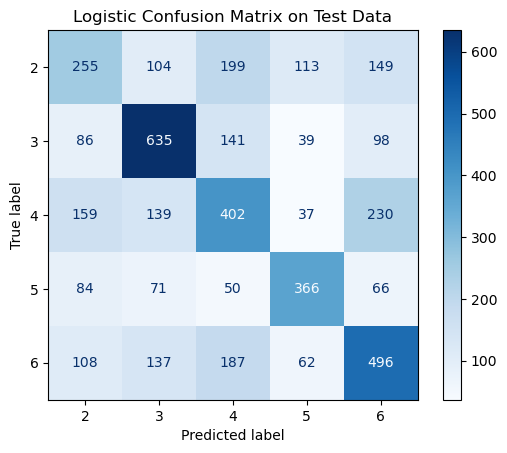

In [17]:
# Confusion Matrix
classes = np.unique(processed_labels)  # Define class names dynamically

# Plot Confusion Matrix for logistic
cm_log = confusion_matrix(y_test, y_test_pred_log)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=classes)
disp_log.plot(cmap=plt.cm.Blues)
plt.title("Logistic Confusion Matrix on Test Data")
plt.show()

In [18]:
print(classification_report(y_train, y_train_pred_log))

              precision    recall  f1-score   support

           2       0.56      0.46      0.50      3277
           3       0.66      0.74      0.70      4001
           4       0.54      0.55      0.54      3863
           5       0.70      0.70      0.70      2534
           6       0.59      0.62      0.60      3975

    accuracy                           0.61     17650
   macro avg       0.61      0.61      0.61     17650
weighted avg       0.61      0.61      0.61     17650



In [19]:
print(classification_report(y_test, y_test_pred_log))

              precision    recall  f1-score   support

           2       0.37      0.31      0.34       820
           3       0.58      0.64      0.61       999
           4       0.41      0.42      0.41       967
           5       0.59      0.57      0.58       637
           6       0.48      0.50      0.49       990

    accuracy                           0.49      4413
   macro avg       0.49      0.49      0.49      4413
weighted avg       0.48      0.49      0.49      4413



C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


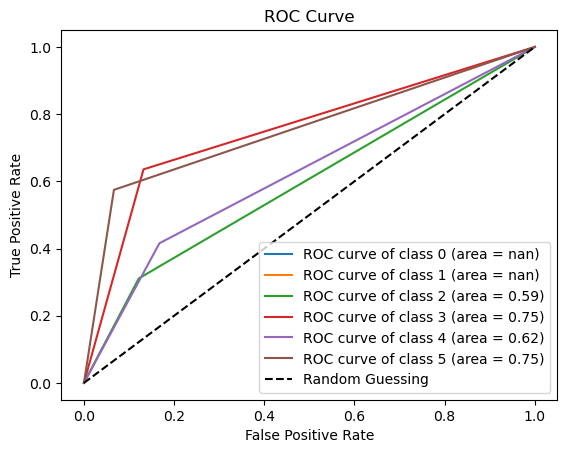

In [20]:
# Assuming y_test contains the true labels and model is your trained classifier
y_pred = logistic.predict(X_test)
y_test = np.array(y_test)
y_pred = np.array(y_pred)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):  # Change num_classes to the number of classes in your dataset
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred == i)  # Binary classification problem for class i
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()

for i in range(6):  # Change num_classes to the number of classes in your dataset
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=15, algorithm="brute")
knn.fit(X_train, y_train)


KNeighborsClassifier(algorithm='brute', n_neighbors=15)

In [22]:
y_train_pred_knn = knn.predict(X_train)
y_test_pred_knn = knn.predict(X_test)

print(f"KNN - Train accuracy: {accuracy_score(y_train, y_train_pred_knn)}")
print(f"KNN - Test accuracy: {accuracy_score(y_test, y_test_pred_knn)}")

KNN - Train accuracy: 0.5741643059490085
KNN - Test accuracy: 0.489689553591661


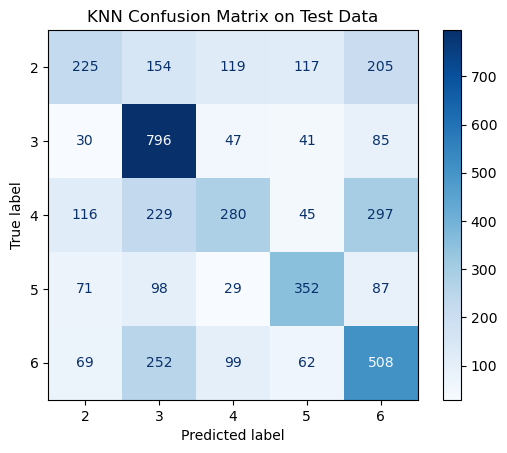

In [23]:
# Confusion Matrix
classes = np.unique(processed_labels)  # Define class names dynamically

# Plot Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_test_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=classes)
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("KNN Confusion Matrix on Test Data")
plt.show()

In [24]:
print(classification_report(y_train, y_train_pred_knn))

              precision    recall  f1-score   support

           2       0.57      0.36      0.44      3277
           3       0.56      0.84      0.67      4001
           4       0.60      0.40      0.48      3863
           5       0.67      0.63      0.65      2534
           6       0.53      0.62      0.57      3975

    accuracy                           0.57     17650
   macro avg       0.59      0.57      0.56     17650
weighted avg       0.58      0.57      0.56     17650



In [25]:
print(classification_report(y_test, y_test_pred_knn))

              precision    recall  f1-score   support

           2       0.44      0.27      0.34       820
           3       0.52      0.80      0.63       999
           4       0.49      0.29      0.36       967
           5       0.57      0.55      0.56       637
           6       0.43      0.51      0.47       990

    accuracy                           0.49      4413
   macro avg       0.49      0.49      0.47      4413
weighted avg       0.49      0.49      0.47      4413



C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


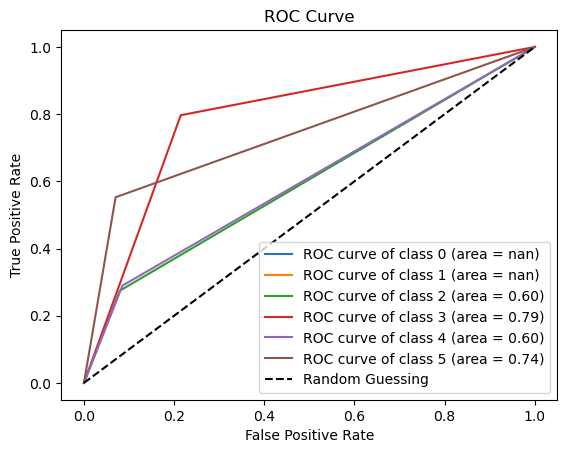

In [26]:
# Assuming y_test contains the true labels and model is your trained classifier
y_pred = knn.predict(X_test)
y_test = np.array(y_test)
y_pred = np.array(y_pred)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):  # Change num_classes to the number of classes in your dataset
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred == i)  # Binary classification problem for class i
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()

for i in range(6):  # Change num_classes to the number of classes in your dataset
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()